**Project: Explainable AI for Parkinsons Disease Classification Using Spiral Drawings**

# Testing VGG19+InceptionV3 with LIME
Paper : Explainable Artificial Intelligence (EXAI) Models for Early Prediction of Parkinson’s Disease Based on Spiral and Wave Drawings

https://ieeexplore.ieee.org/document/10171347

In this section we carry out the methodology of the aforementioned paper for classification of spiral and wave drawings

The dataset used was : https://www.kaggle.com/datasets/kmader/parkinsons-drawings

The other dataset used contained spiral, meander, wave drawings on top of a drawing, and was excluded for simplicity.

The distribution total => 51 PD and 51 Healthy (including Training and Testing)

It was augmented using the mentioned augmentation methods (Shearing, Rotation and Flipping) to a distribution of 500 PD and 503 Healthy

The zipfile of this augmented dataset -> pd_augmented_data.zip \
Available at : https://www.kaggle.com/datasets/mukundhj/parkinsons-disease-augmented

DA1 Presentation: https://docs.google.com/presentation/d/1zO2J0kPnWWx6j2Y-OZPEiHnRMLQGmIeyOKFTCOGVtD4/edit?usp=sharing

## Import Dependencies

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
import os
import zipfile
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

## Loading the Data

In [ ]:
# Step 1: Extract the ZIP file
zip_path = "pd_augmented_data.zip"  # Path to the zip file
extract_path = "./data"  # Directory where data will be extracted

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 2: Define paths
data_dir = os.path.join(extract_path, "augmented_data")
print(f"Data extracted to: {data_dir}")



Data extracted to: ./data/augmented_data


In [ ]:
# Step 3: Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

# Step 4: Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Step 5: Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% training data
val_size = len(dataset) - train_size  # 20% validation data
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Step 6: Create DataLoaders
batch_size = 32  # Adjust based on memory capacity
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print dataset details
class_names = dataset.classes
print(f"Classes: {class_names}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Classes: ['augmented_healthy', 'augmented_parkinson']
Training samples: 802
Validation samples: 201


## Define the VGG19-INC Hybrid Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class VGG19_INCEPTION(nn.Module):
    def __init__(self, num_classes):
        super(VGG19_INCEPTION, self).__init__()

        # Load pre-trained VGG19 model and extract features
        vgg19 = models.vgg19(pretrained=True)
        self.vgg19_features = vgg19.features

        # Batch Normalization after VGG19 feature extraction
        self.batch_norm = nn.BatchNorm2d(512)  # 512 channels from VGG19

        # Inception module
        self.inception = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),  # 1x1 convolution
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 3x3 convolution
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=5, padding=2),  # 5x5 convolution
            nn.ReLU(inplace=True),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Assuming input image size is 224x224
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        # VGG19 feature extraction
        x = self.vgg19_features(x)

        # Apply Batch Normalization after VGG19
        x = self.batch_norm(x)

        # Inception module
        x = self.inception(x)
        x = torch.flatten(x, start_dim=1)

        # Classification
        x = self.classifier(x)
        return x


##Initialize the Model

In [ ]:
# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the model
num_classes = 2  # Binary classification (PD vs Healthy)
model = VGG19_INCEPTION(num_classes=num_classes)
model.to(device)
# Freeze initial VGG19 layers
for param in model.vgg19_features[:10].parameters():
    param.requires_grad = False


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 139MB/s]


##Define Optimizer, Loss Function, and Scheduler

In [ ]:
# Define optimizer with differential learning rates
optimizer = optim.Adam([
    {'params': model.vgg19_features.parameters(), 'lr': 1e-4},
    {'params': model.inception.parameters(), 'lr': 1e-3},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])

# Define loss function
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


##Define Data Transformations

In [ ]:
# Data augmentation and preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

##Training and Validation Loop

###Model

In [ ]:
import matplotlib.pyplot as plt

# Initialize history dictionaries
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': []
}

# Training and validation loop with history tracking
num_epochs = 20
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    history['train_loss'].append(train_loss)

    # Validation phase
    model.eval()
    val_loss, val_accuracy = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            val_accuracy += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader.dataset)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    scheduler.step()

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_vgg19_inception_pd.pth")
        print("Model improved. Saving the model.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epochs.")

    if epochs_without_improvement >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Load the best model after training
model.load_state_dict(torch.load("best_vgg19_inception_pd.pth"))
print("Best model loaded.")


Epoch 1/20, Train Loss: 0.0372, Val Loss: 0.0687, Val Acc: 0.9652
Model improved. Saving the model.
Epoch 2/20, Train Loss: 0.0314, Val Loss: 0.0652, Val Acc: 0.9652
Model improved. Saving the model.
Epoch 3/20, Train Loss: 0.0156, Val Loss: 0.0765, Val Acc: 0.9701
No improvement for 1 epochs.
Epoch 4/20, Train Loss: 0.0089, Val Loss: 0.0474, Val Acc: 0.9851
Model improved. Saving the model.
Epoch 5/20, Train Loss: 0.0043, Val Loss: 0.0577, Val Acc: 0.9851
No improvement for 1 epochs.
Epoch 6/20, Train Loss: 0.0043, Val Loss: 0.0555, Val Acc: 0.9851
No improvement for 2 epochs.
Epoch 7/20, Train Loss: 0.0036, Val Loss: 0.0500, Val Acc: 0.9851
No improvement for 3 epochs.
Epoch 8/20, Train Loss: 0.0074, Val Loss: 0.0384, Val Acc: 0.9900
Model improved. Saving the model.
Epoch 9/20, Train Loss: 0.0065, Val Loss: 0.0564, Val Acc: 0.9851
No improvement for 1 epochs.
Epoch 10/20, Train Loss: 0.0043, Val Loss: 0.0557, Val Acc: 0.9851
No improvement for 2 epochs.
Epoch 11/20, Train Loss: 0.00

<ipython-input-9-fff7d736bb2d>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vgg19_inception_pd.pth"))


Best model loaded.


###Plotting the Training History

In [ ]:
history

{'train_loss': [0.0371987266861162,
  0.031442193063692406,
  0.015612693281862168,
  0.008914577538514724,
  0.004295140787899772,
  0.004295529159627711,
  0.0036127684645372517,
  0.007421642687404528,
  0.006521536331722298,
  0.004300324883213482,
  0.0014638161838565094,
  0.0027560574028308283,
  0.001310719420031931],
 'val_loss': [0.0687366806502853,
  0.06517300462084157,
  0.076499681653721,
  0.047422088283513276,
  0.05772389571315476,
  0.055535227459456236,
  0.05003789725846478,
  0.03839338743793113,
  0.056358554999211004,
  0.05570150259882212,
  0.06767999587048378,
  0.04193377215415239,
  0.04790558373289449],
 'val_accuracy': [0.9651741293532339,
  0.9651741293532339,
  0.9701492537313433,
  0.9850746268656716,
  0.9850746268656716,
  0.9850746268656716,
  0.9850746268656716,
  0.9900497512437811,
  0.9850746268656716,
  0.9850746268656716,
  0.9800995024875622,
  0.9850746268656716,
  0.9850746268656716]}

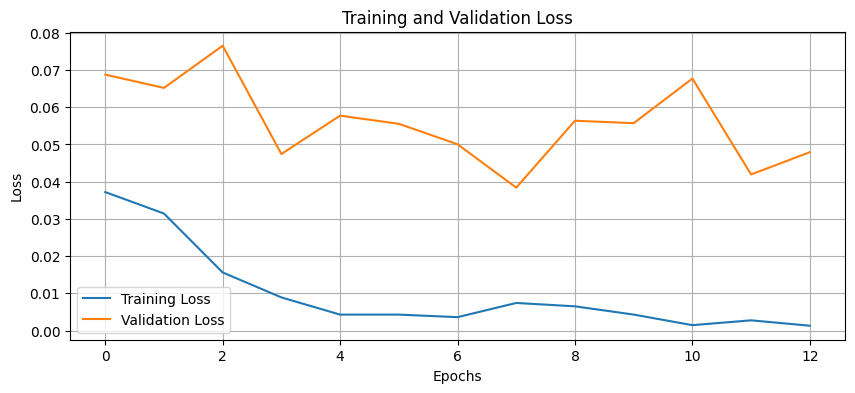

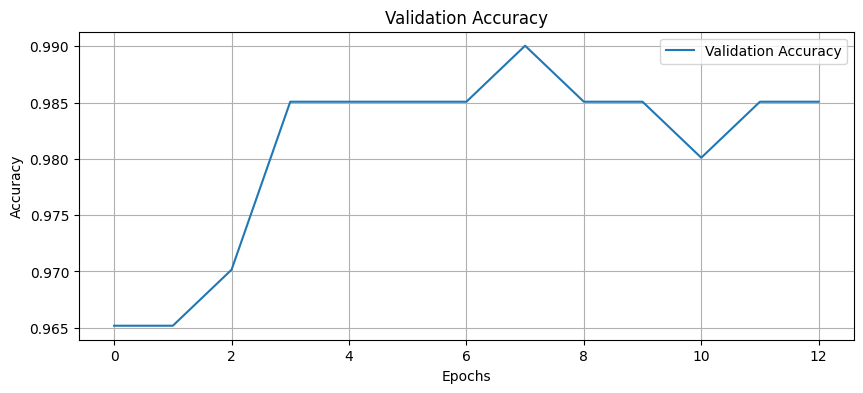

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


##LIME

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=29a26d2c97479ecd423fc3849ba2c121a2052b4312e69ad7573b0b26ae0c8e28
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


###Define a Wrapper for the Model

In [ ]:
from lime import lime_image
from torchvision.transforms.functional import normalize, resize, to_tensor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Define the explanation function
def explain_with_lime(image_path, model, device, top_labels=2, num_features=5, num_samples=1000):
    # Define a model wrapper
    class ModelWrapper:
        def __init__(self, model):
            self.model = model
            self.model.eval()  # Set the model to evaluation mode

        def __call__(self, images):
            images = torch.stack([to_tensor(img).to(device) for img in images])
            images = normalize(images, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            outputs = self.model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            return probabilities.cpu().detach().numpy()

    # Instantiate the model wrapper
    model_wrapper = ModelWrapper(model)

    # Load and preprocess the image
    sample_image = Image.open(image_path).convert('RGB')
    sample_image_resized = resize(sample_image, [224, 224])

    # Initialize LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Generate explanations
    explanation = explainer.explain_instance(
        np.array(sample_image_resized),  # Input image as numpy array
        model_wrapper,                   # Wrapped model
        top_labels=top_labels,           # Number of top classes to explain
        hide_color=0,                    # Background color for masked areas
        num_samples=num_samples          # Number of perturbed samples
    )

    # Visualize explanations for the top predicted class
    top_class = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        label=top_class,
        positive_only=True,
        num_features=num_features,
        hide_rest=False
    )

    # Plot the explanation
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"Explanation for Class {top_class}")
    plt.axis('off')
    plt.show()




###Apply LIME to an Image

  0%|          | 0/1000 [00:00<?, ?it/s]

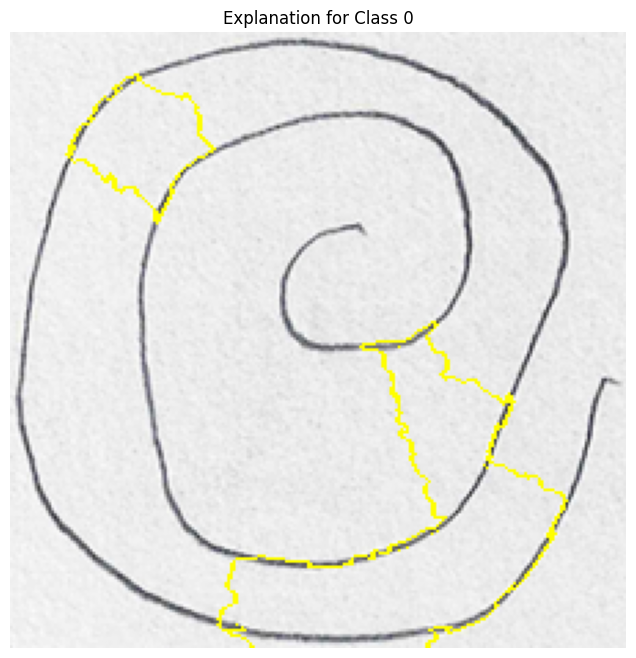

In [ ]:
# Example usage
explain_with_lime('/content/data/augmented_data/augmented_healthy/V01HE01.png', model, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

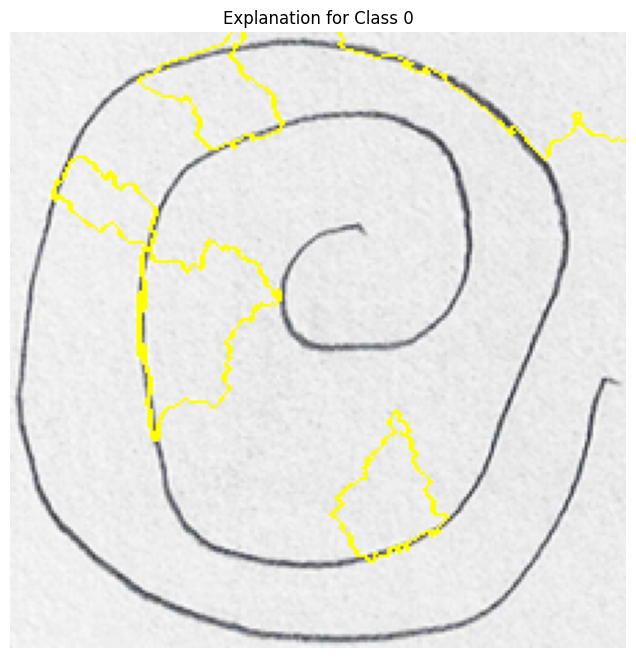

In [ ]:
explain_with_lime('/content/data/augmented_data/augmented_healthy/V01HE01.png', model, device)


  0%|          | 0/1000 [00:00<?, ?it/s]

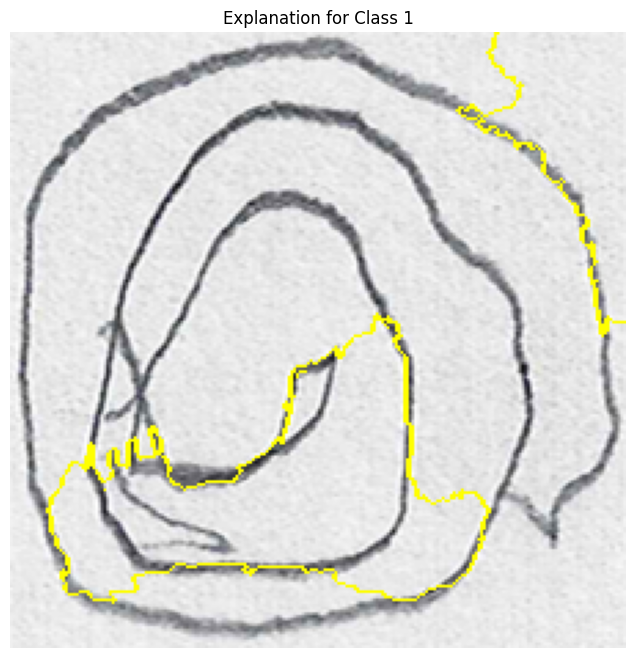

In [ ]:
explain_with_lime('/content/data/augmented_data/augmented_parkinson/V04PE01.png', model, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

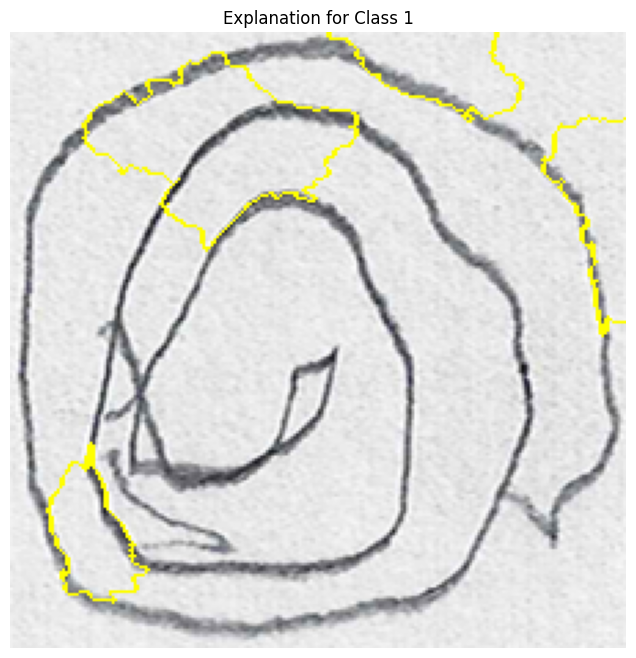

In [ ]:
explain_with_lime('/content/data/augmented_data/augmented_parkinson/V04PE01.png', model, device)

As we can observe, for the same image, the explanations are inconsistent (For class 0 and 1). This validates the limitation of LIME, which is unstable explanations.

Though the VGG19+InceptionV3 Model achieves high accuracy, accuracy does not explain everything about a model's performance and correctness.

# Implementing SLICE with some blackbox model on two test samples
Paper: SLICE- Stabilized LIME for Consistent Explanations for Image Classification

https://openaccess.thecvf.com/content/CVPR2024/papers/Bora_SLICE_Stabilized_LIME_for_Consistent_Explanations_for_Image_Classification_CVPR_2024_paper.pdf

GITHUB: https://github.com/rebathip/SLICE-Stabilized-LIME-for-Consistent-Explanations-for-Image-Classification.git

### Preparation

In [ ]:
!git clone https://github.com/rebathip/SLICE-Stabilized-LIME-for-Consistent-Explanations-for-Image-Classification.git

Cloning into 'SLICE-Stabilized-LIME-for-Consistent-Explanations-for-Image-Classification'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 66 (delta 29), reused 16 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 1.16 MiB | 3.73 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [ ]:
!unzip pd_augmented_data.zip

Archive:  pd_augmented_data.zip
   creating: augmented_data/
  inflating: __MACOSX/._augmented_data  
   creating: augmented_data/augmented_healthy/
  inflating: augmented_data/.DS_Store  
  inflating: __MACOSX/augmented_data/._.DS_Store  
   creating: augmented_data/augmented_parkinson/
  inflating: augmented_data/augmented_healthy/aug_0_9528.jpg  
  inflating: augmented_data/augmented_healthy/V09HE02.png  
  inflating: __MACOSX/augmented_data/augmented_healthy/._V09HE02.png  
  inflating: augmented_data/augmented_healthy/aug_0_2858.jpg  
  inflating: augmented_data/augmented_healthy/V55HE06.png  
  inflating: __MACOSX/augmented_data/augmented_healthy/._V55HE06.png  
  inflating: augmented_data/augmented_healthy/V55HE12.png  
  inflating: __MACOSX/augmented_data/augmented_healthy/._V55HE12.png  
  inflating: augmented_data/augmented_healthy/aug_0_9058.jpg  
  inflating: augmented_data/augmented_healthy/aug_0_6551.jpg  
  inflating: augmented_data/augmented_healthy/aug_0_6974.jpg  
  i

In [ ]:
def create_image_directory():
  # Create the directory if it doesn't exist
  if not os.path.exists('/content/images_pdh/'):
    os.makedirs('/content/images_pdh/')

  # Copy the specified files to the images directory
  shutil.copy('/content/augmented_data/augmented_healthy/V01HE01.png', '/content/images_pdh') #healthy
  shutil.copy('/content/augmented_data/augmented_parkinson/V03PE01.png', '/content/images_pdh') #pd

### Moving the SLICE library to the working directory

In [ ]:
import shutil
import os

# Move the slice folder to /content
!mv /content/SLICE-Stabilized-LIME-for-Consistent-Explanations-for-Image-Classification/slice /content/


### Loading Dependencies

In [ ]:
import os
import pickle
import numpy as np
import cv2
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io
from skimage.segmentation import quickshift, mark_boundaries
from skimage.measure import regionprops
import copy
import random
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from skimage import filters
import pandas as pd
import warnings
import tensorflow as tf
import pickle
import sys
from scipy.stats import kendalltau

from matplotlib import pyplot as plt
import time
from sklearn.utils import resample
from scipy.stats import norm, gaussian_kde
from sklearn.neighbors import KernelDensity
import csv
from slice.slice_explainer import SliceExplainer
from slice.vit_img_classifier import ViTImageClassifier

In [ ]:
create_image_directory()

In [ ]:
def create_directory_and_file(directory):
  """Creates a directory and a file within it with specified content."""
  try:
    os.makedirs(directory, exist_ok=True)
    print(f"Directories '{directory}' created successfully.")
  except Exception as e:
    print(f"Error creating directory or file: {e}")


In [ ]:
directory = '/content/results/pdh/slice_inceptionv3'


In [ ]:
create_directory_and_file(directory)

Directories '/content/results/pdh/slice_inceptionv3' created successfully.


In [ ]:
img_dir = "/content/images_pdh/"
try:
    img_filenames = os.listdir(img_dir)
except IndexError:
    print("No files found in the directory.")

algo_name = "slice"
results_dir = "/content/results/"
num_runs = 1
sample_size = 500
tol = 3 # tolerance parameter for feature elimination algorithm

##### Blackbox model described in implementation

In [ ]:
model = tf.keras.applications.InceptionV3(weights='imagenet')
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
decode_predictions = tf.keras.applications.inception_v3.decode_predictions
target_img_size = (299, 299)

96112376/96112376 [==============================] - 1s 0us/step


In [ ]:
model_name = model.name
model_name = model_name.replace("_", "")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.segmentation
import skimage.color

Custom Function to plot the positive and negatively associated segments

In [ ]:
def plot_segments(image_path, segments, pos_indices, neg_indices):
    # Load the image
    image = skimage.io.imread(image_path)
    image = skimage.transform.resize(image, (segments.shape[0], segments.shape[1]))

    # Create masks for positive and negative regions
    pos_mask = np.isin(segments, pos_indices)
    neg_mask = np.isin(segments, neg_indices)

    # Create overlays
    overlay = image.copy()
    overlay[pos_mask] = [1, 0, 0]  # Red for positive
    overlay[neg_mask] = [0, 0, 1]  # Blue for negative

    # Plot the original image, segments, and overlays
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(mark_boundaries(image, segments))
    ax[1].set_title("Segmented Image")
    ax[1].axis("off")

    ax[2].imshow(mark_boundaries(overlay, segments))
    ax[2].set_title("Highlighted Segments")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
img_filenames

['V01HE01.png', 'V03PE01.png']

In [ ]:
imAge_directory= f"/content/images_pdh/{img_filenames[0]}"

In [ ]:
imAge_directory

'/content/images_pdh/V01HE01.png'

#### SLICE - Num runs = 1
The study claims that for most models the stable explanations with SLICE can be achieved with just 1 run

In [ ]:
num_runs=1

/content/results/pdh/slice_inceptionv3/pdh_slice_V01HE01_inceptionv3.pkl
[0.07470165631979098, -0.0012244766102711413, 0.03959595779099423, 0.9973522136736712, 0.9662474470015001, 0.811065993213757] non nan selected= 0.3
sel_sigma:0.3
V01HE01.png  :  45  :  500
******Non Zero Indices:  [ 4  9 21 35 43]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [ 2 15 16  1 36 12 26  3 24 30 32  6 41  0 25  8 33]
neg: [38 28 18 37  5 19 14 11  7 27 39 22 13 29 17 31 44 40 34 42 10 20 23]
/content/results/pdh/slice_inceptionv3/pdh_slice_V01HE01_inceptionv3.pkl


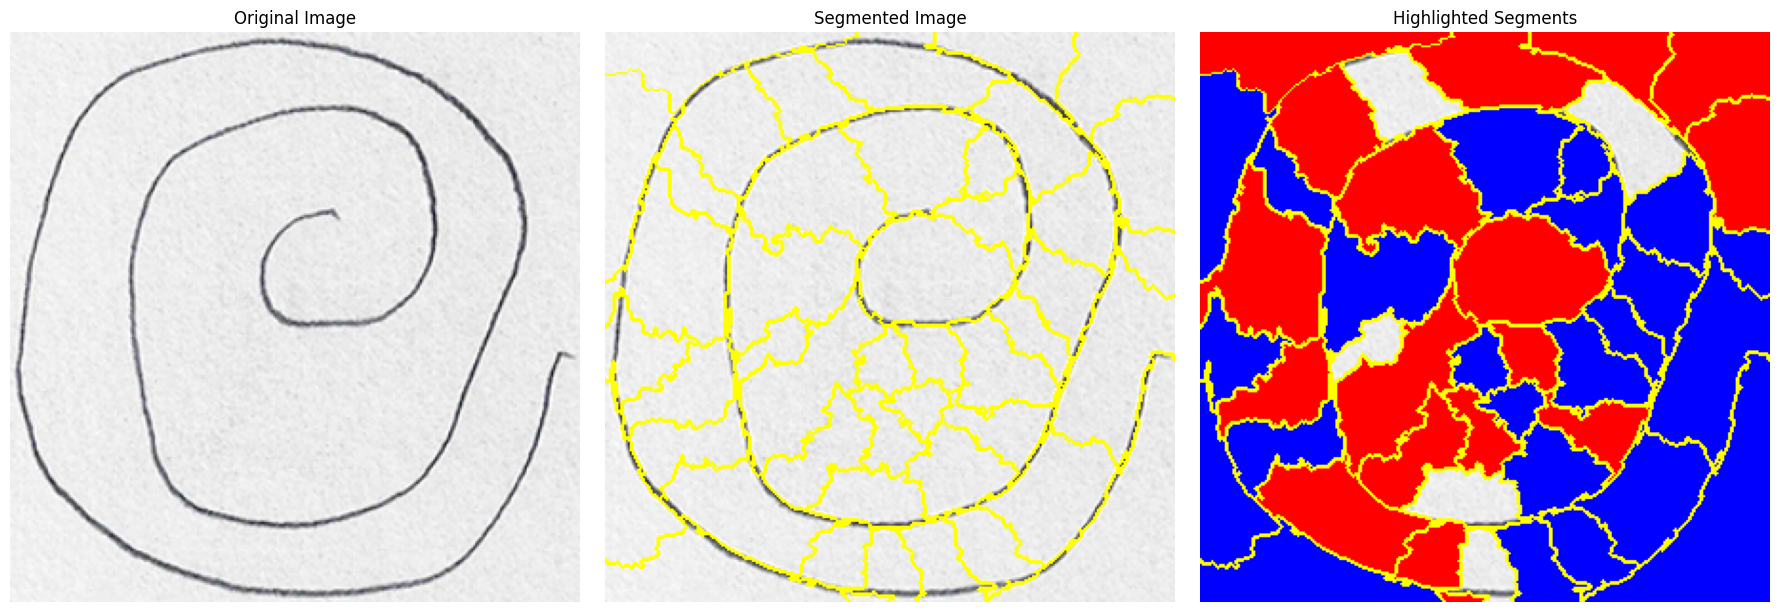

/content/results/pdh/slice_inceptionv3/pdh_slice_V03PE01_inceptionv3.pkl
[0.08435296565580541, 0.005483890738014696, 0.05481359091381266, 0.9976668688455806, 0.9388614295016685, 0.7417204321303508] non nan selected= 0.3
sel_sigma:0.3
V03PE01.png  :  38  :  500
******Non Zero Indices:  [9]
******Non Zero Indices:  [25]
******Non Zero Indices:  []
******Non Zero Indices:  [17]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [11 33 37  0 22  2 30  8 13  4  7  3 29 35 36 23 34  1]
neg: [21 25 20 28 12 24 27 31 10 16 15  6 19 32  5 17 14]
/content/results/pdh/slice_inceptionv3/pdh_slice_V03PE01_inceptionv3.pkl


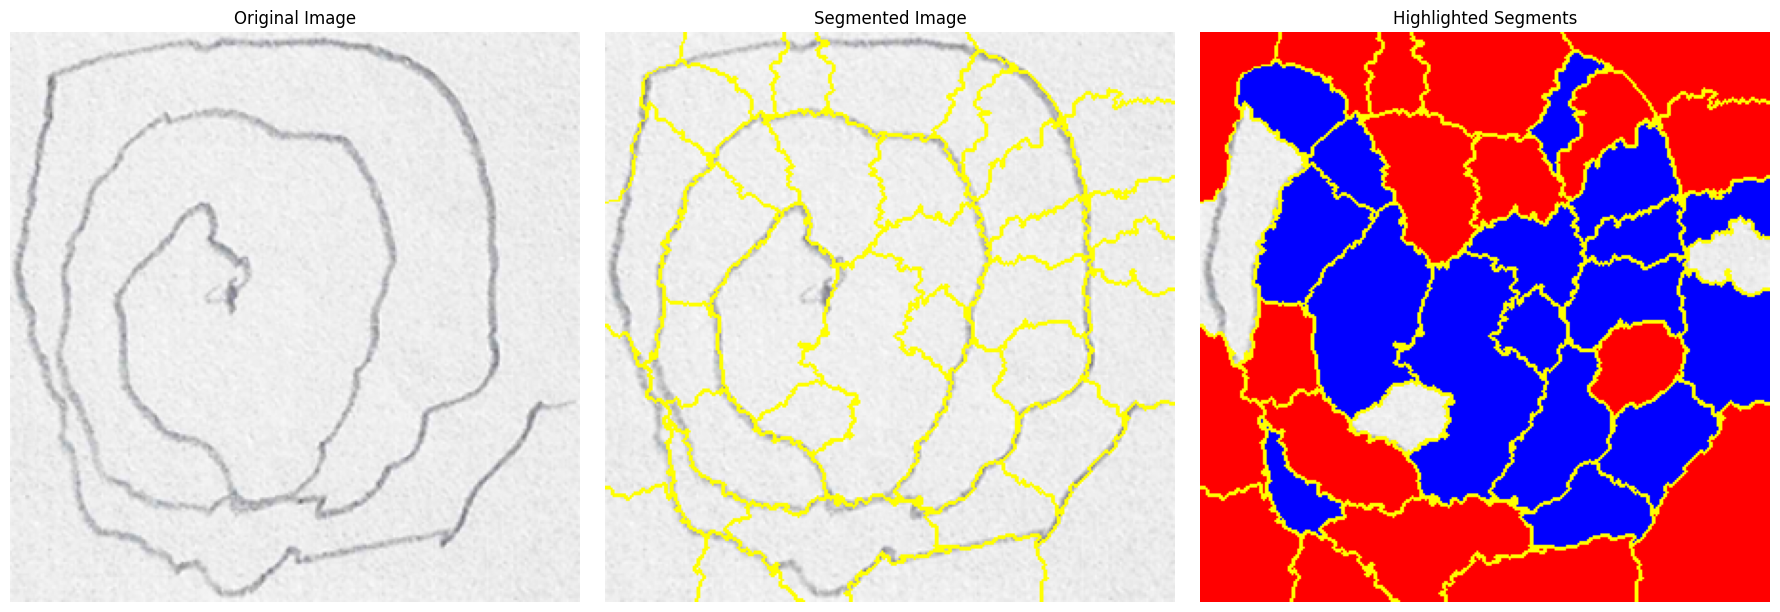

In [ ]:
for img_filename in img_filenames:
    img_dict = {}
    img_dir_name = (img_dir.split("_")[1]).split("/")[0]
    img_filename_split = (img_filename.split(".jpg") if ".jpg" in img_filename else img_filename.split(".png"))[0]

    pkl_filename = results_dir + img_dir_name + "/" + algo_name + "_" + model_name + "/" + img_dir_name + "_" + \
                   algo_name + "_" + img_filename_split + "_" + model_name + ".pkl"
    print(pkl_filename) # the sub-dir inside results_dir should be present


    seg_img = skimage.io.imread(img_dir + img_filename)
    seg_img = skimage.transform.resize(seg_img, target_img_size)
    # too many segments will increase the computation time
    segments = skimage.segmentation.quickshift(seg_img, kernel_size=5, max_dist=200, ratio=0.2)
    exp = SliceExplainer(image_path=img_dir + img_filename, segments=segments, model=model, \
                         target_img_size=target_img_size, preprocess=preprocess_input)
    sel_sigma = exp.select_sigma() # normally 0.3 works in most cases
    del exp

    print("sel_sigma:" + str(sel_sigma))
    run_dict = {}
    for i in np.arange(0, num_runs, step=1):
        # image_path=img_dir + img_filename
        exp = SliceExplainer(image_path=img_dir + img_filename, segments=segments, model=model, \
                             target_img_size=target_img_size, preprocess=preprocess_input)
        print(img_filename, " : ", len(np.unique(exp.superpixels)), " : ", sample_size)
        unstable_features, pos_feature_ranks, neg_feature_ranks, num_samples_used, pos_dict, neg_dict\
            = exp.get_slice_explanations(num_perturb=sample_size, tolerance_limit=tol, sigma=sel_sigma,
                                         rank_stabilization=False)

        print("pos: " + str(pos_feature_ranks))
        print("neg: " + str(neg_feature_ranks))

        ranks = {'pos': pos_feature_ranks.tolist() if len(pos_feature_ranks) > 0 else np.array([]),
                 'neg': neg_feature_ranks.tolist() if len(neg_feature_ranks) > 0 else np.array([]),
                 'pos_dict': pos_dict, 'neg_dict': neg_dict, 'sel_sigma': sel_sigma,
                 'h_unstable': unstable_features, 'num_samples': num_samples_used}

        if f'run_{i}' not in run_dict:
            run_dict[f'run_{i}'] = []

        del exp
        #
        run_dict[f'run_{i}'].append(ranks)
        img_key = img_filename.split('.')[0]

    if f'run_{img_key}' not in img_dict:
        img_dict[f'run_{img_key}'] = []

    img_dict[f'run_{img_key}'].append(run_dict)

    # # save the selected feature ranks in a dict and save it in a pkl file
    print(pkl_filename)
    with open(pkl_filename, 'wb') as f1:
        pickle.dump(img_dict, f1)

    if len(ranks['pos'])>0 or len(ranks['neg'])>0:
          plot_segments(f"/content/images_pdh/{img_filename}", segments, ranks['pos'], ranks['neg'])


#### Num runs = 3 to see how it varies accross multiple runs

In [ ]:
num_runs=3

/content/results/pdh/slice_inceptionv3/pdh_slice_V01HE01_inceptionv3.pkl
[0.053944547331873594, 0.019136504216307526, 0.031504836204267694, 0.9976619195705604, 0.9665399619165406, 0.8450773140680445] non nan selected= 0.3
sel_sigma:0.3
V01HE01.png  :  45  :  500
******Non Zero Indices:  [ 9 21 35 43]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [ 2 15  1 16 36 26 12  3 30 24 32  6 41  0 25  8 33  4]
neg: [38 28 18 37  5 19 14  7 11 39 27 22 13 29 17 31 44 40 34 42 10 23 20]


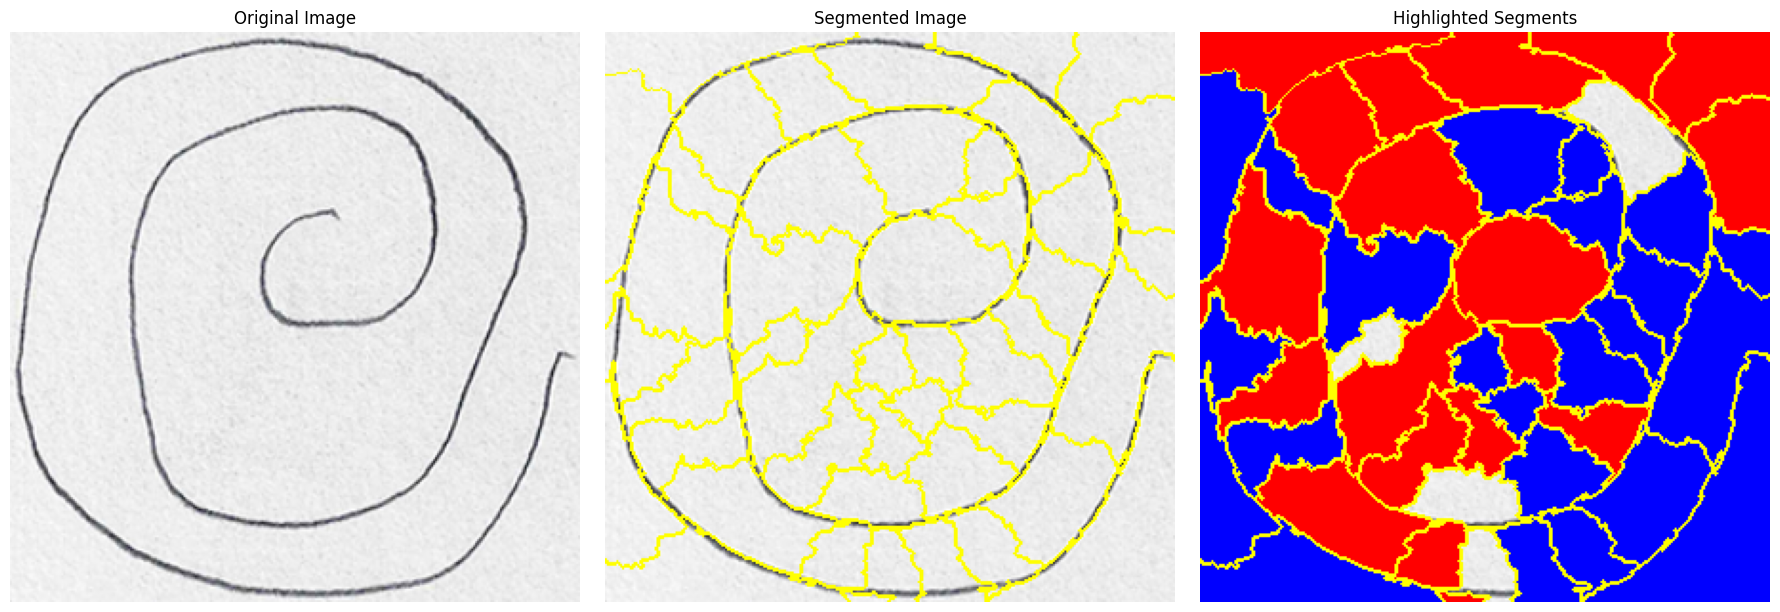

V01HE01.png  :  45  :  500
******Non Zero Indices:  [ 9 35 43]
******Non Zero Indices:  [20]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [ 2 15 16  1 36 12 26  3 24 32 30  6 41  0 25  8  4 33]
neg: [38 28 18 37  5 19 14 11  7 39 27 22 13 29 17 31 44 34 40 42 10 23 20]


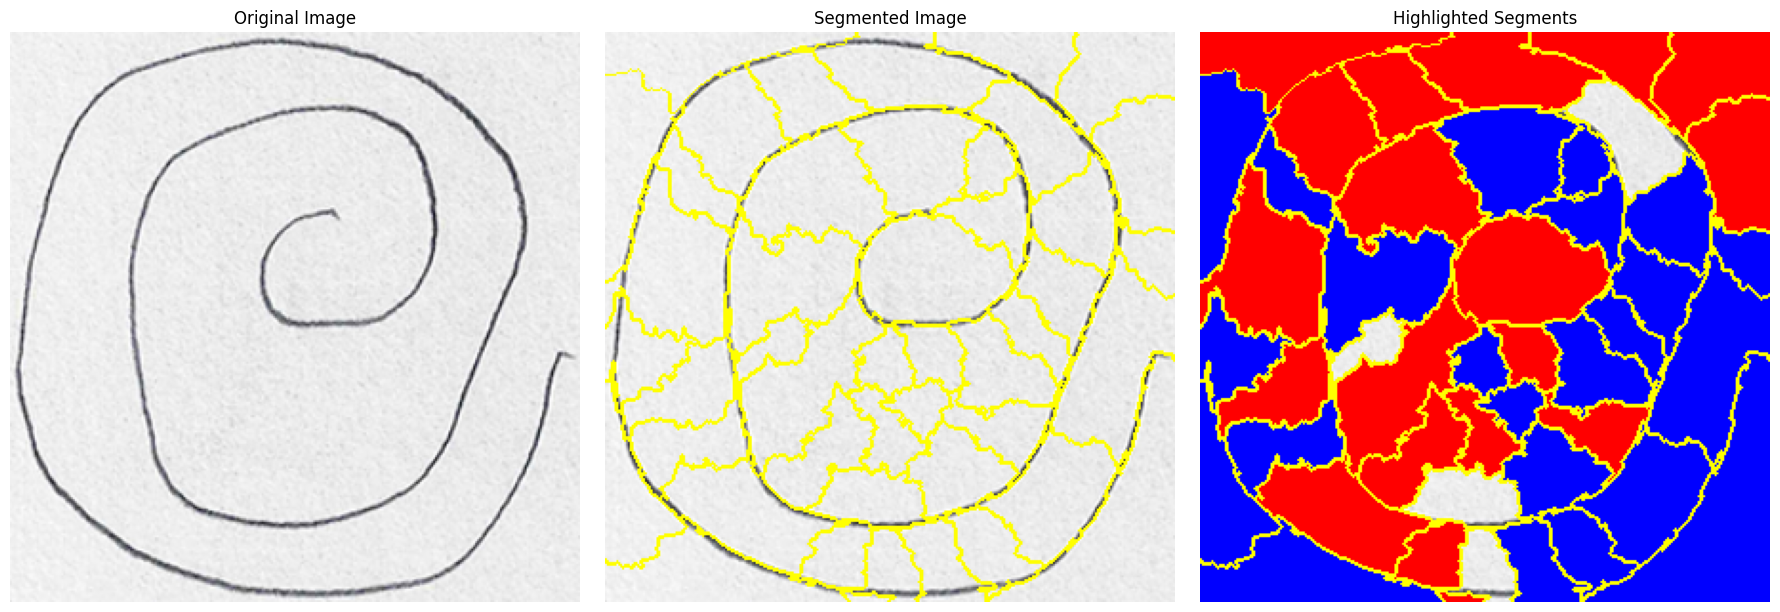

V01HE01.png  :  45  :  500
******Non Zero Indices:  [ 9 21 35 43]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [ 2 15  1 16 36 12 26  3 30 24 32  6 41  0 25  8 33  4]
neg: [38 28 18 37  5 19 14 11  7 39 27 22 13 29 17 31 44 40 34 42 10 23 20]


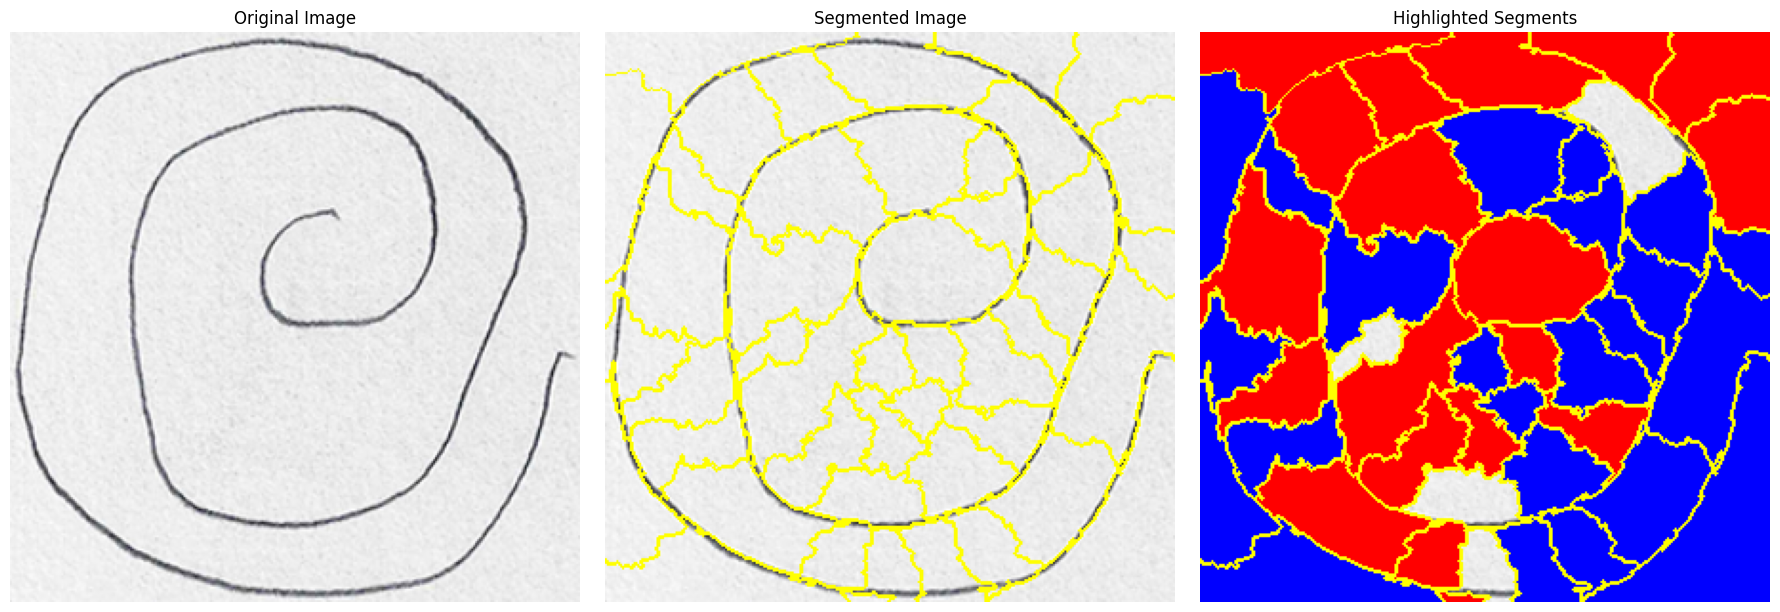

/content/results/pdh/slice_inceptionv3/pdh_slice_V01HE01_inceptionv3.pkl
/content/results/pdh/slice_inceptionv3/pdh_slice_V03PE01_inceptionv3.pkl
[0.05963539151491226, -0.00205352880579035, 0.0029249745499230206, 0.9978258958554271, 0.9343759590918157, 0.6638444460498591] non nan selected= 0.3
sel_sigma:0.3
V03PE01.png  :  38  :  500
******Non Zero Indices:  [18 26]
******Non Zero Indices:  [9]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [11 33 37  0 22 30  2  8 13  4  7  3 29 35 36 23 34  1]
neg: [21 25 20 28 12 24 27 10 31 16 15  6 19 32  5 17 14]


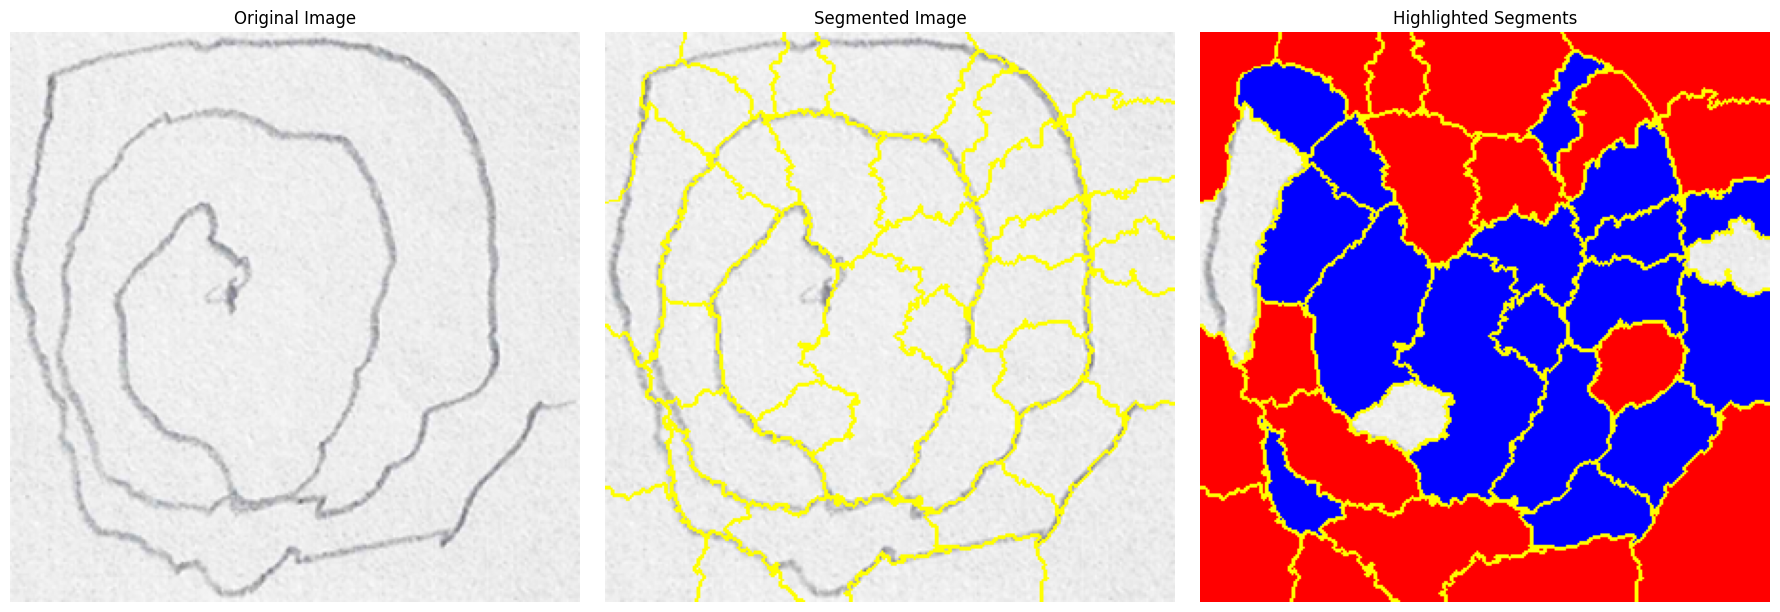

V03PE01.png  :  38  :  500
******Non Zero Indices:  [ 9 26]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  [17]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [11 33 37  0 22  2 30  8 13  4  7  3 29 35 36 34 23  1]
neg: [21 25 28 20 24 12 27 31 10 16 15  6 19 32  5 17 14]


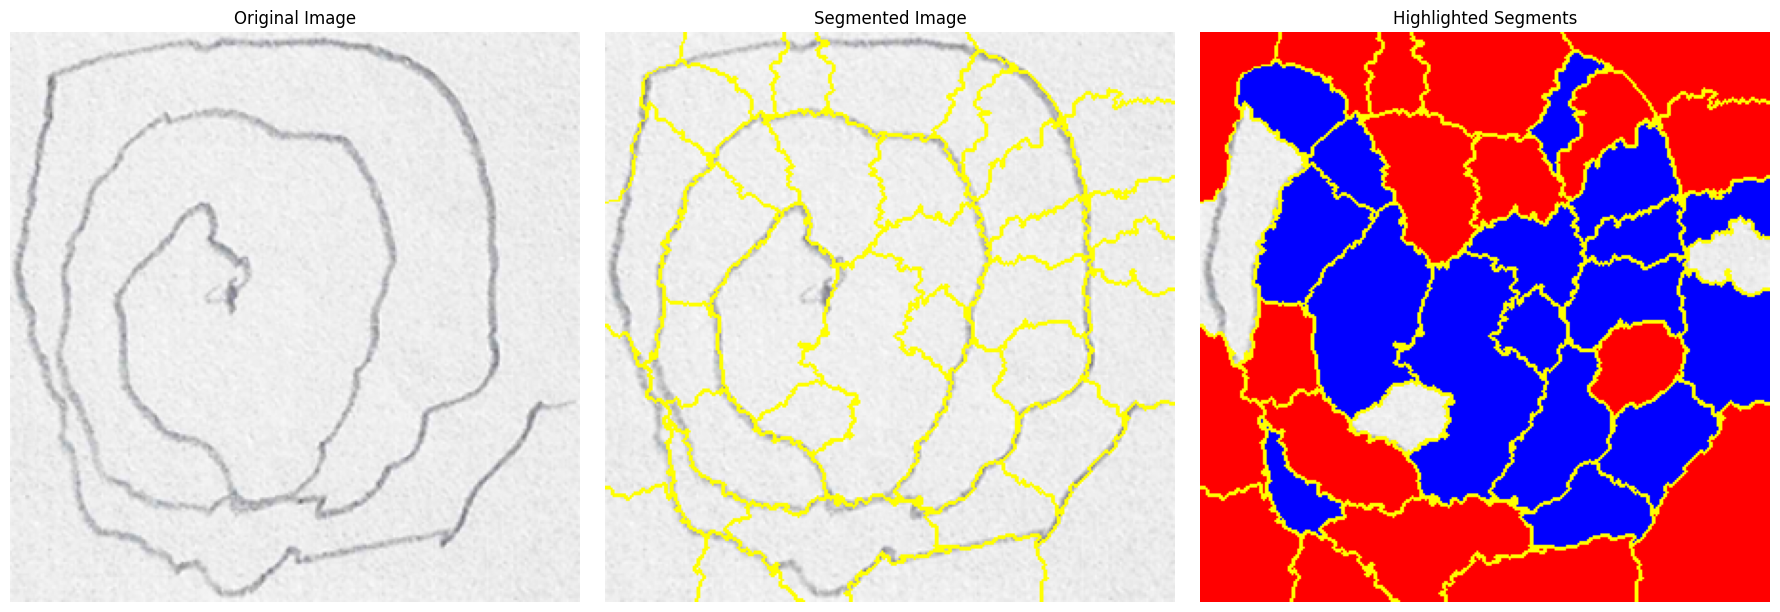

V03PE01.png  :  38  :  500
******Non Zero Indices:  [26]
******Non Zero Indices:  [9]
******Non Zero Indices:  []
******Non Zero Indices:  [17]
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
******Non Zero Indices:  []
pos: [11 33 37  0 22  2 30  8 13  4  7  3 35 29 36 34 23  1]
neg: [21 25 20 28 24 12 27 10 31 16 15  6 32 19  5 17 14]


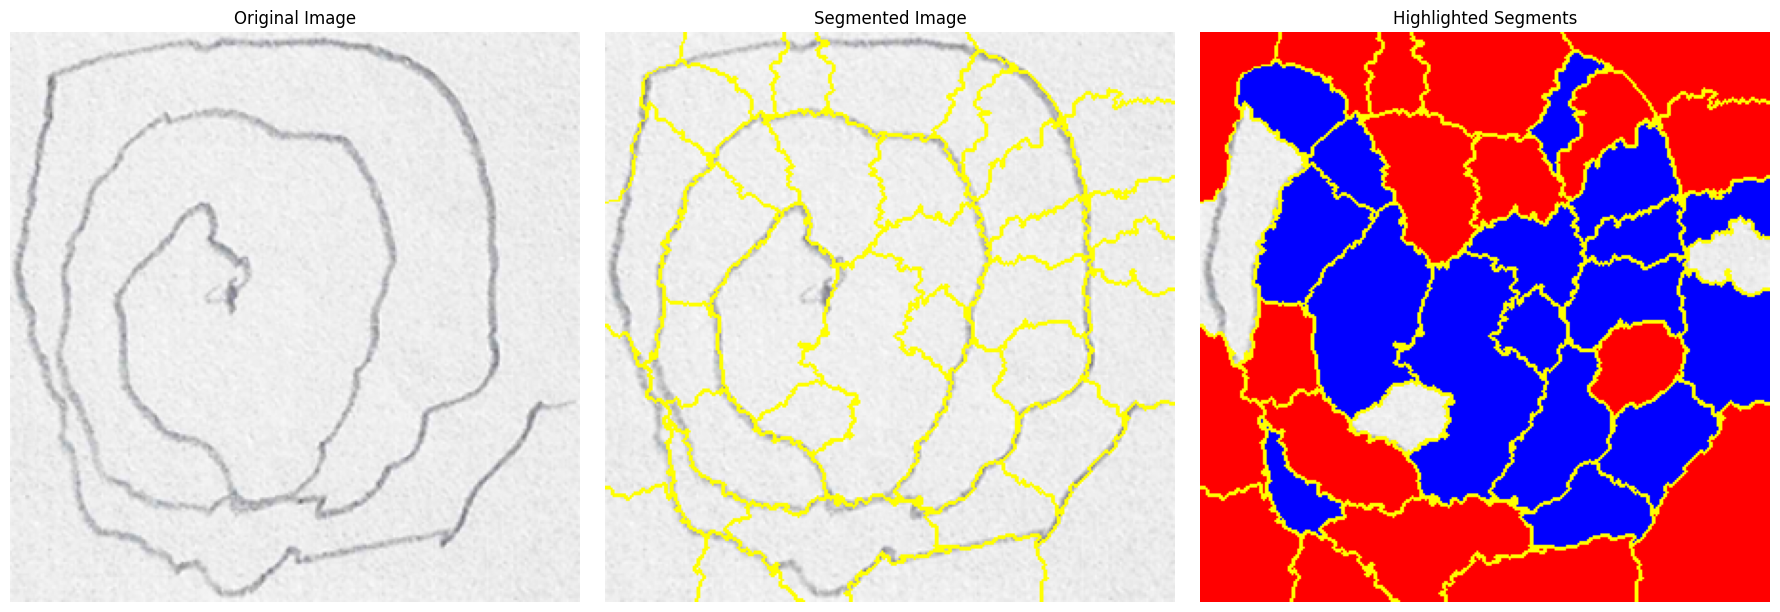

/content/results/pdh/slice_inceptionv3/pdh_slice_V03PE01_inceptionv3.pkl


In [ ]:
for img_filename in img_filenames:
    img_dict = {}
    img_dir_name = (img_dir.split("_")[1]).split("/")[0]
    img_filename_split = (img_filename.split(".jpg") if ".jpg" in img_filename else img_filename.split(".png"))[0]

    pkl_filename = results_dir + img_dir_name + "/" + algo_name + "_" + model_name + "/" + img_dir_name + "_" + \
                   algo_name + "_" + img_filename_split + "_" + model_name + ".pkl"
    print(pkl_filename) # the sub-dir inside results_dir should be present

    seg_img = skimage.io.imread(img_dir + img_filename)
    seg_img = skimage.transform.resize(seg_img, target_img_size)
    # too many segments will increase the computation time
    segments = skimage.segmentation.quickshift(seg_img, kernel_size=5, max_dist=200, ratio=0.2)
    exp = SliceExplainer(image_path=img_dir + img_filename, segments=segments, model=model, \
                         target_img_size=target_img_size, preprocess=preprocess_input)
    sel_sigma = exp.select_sigma() # normally 0.3 works in most cases
    del exp

    print("sel_sigma:" + str(sel_sigma))
    run_dict = {}
    for i in np.arange(0, num_runs, step=1):
        # image_path=img_dir + img_filename
        exp = SliceExplainer(image_path=img_dir + img_filename, segments=segments, model=model, \
                             target_img_size=target_img_size, preprocess=preprocess_input)
        print(img_filename, " : ", len(np.unique(exp.superpixels)), " : ", sample_size)
        unstable_features, pos_feature_ranks, neg_feature_ranks, num_samples_used, pos_dict, neg_dict\
            = exp.get_slice_explanations(num_perturb=sample_size, tolerance_limit=tol, sigma=sel_sigma,
                                         rank_stabilization=False)

        print("pos: " + str(pos_feature_ranks))
        print("neg: " + str(neg_feature_ranks))

        ranks = {'pos': pos_feature_ranks.tolist() if len(pos_feature_ranks) > 0 else np.array([]),
                 'neg': neg_feature_ranks.tolist() if len(neg_feature_ranks) > 0 else np.array([]),
                 'pos_dict': pos_dict, 'neg_dict': neg_dict, 'sel_sigma': sel_sigma,
                 'h_unstable': unstable_features, 'num_samples': num_samples_used}

        if f'run_{i}' not in run_dict:
            run_dict[f'run_{i}'] = []

        del exp
        #
        run_dict[f'run_{i}'].append(ranks)
        img_key = img_filename.split('.')[0]
        if len(ranks['pos'])>0 or len(ranks['neg'])>0:
          plot_segments(f"/content/images_pdh/{img_filename}", segments, ranks['pos'], ranks['neg'])
    if f'run_{img_key}' not in img_dict:
        img_dict[f'run_{img_key}'] = []

    img_dict[f'run_{img_key}'].append(run_dict)

    # # save the selected feature ranks in a dict and save it in a pkl file
    print(pkl_filename)
    with open(pkl_filename, 'wb') as f1:
        pickle.dump(img_dict, f1)


As we can observe, there is no variation. Moreover, when performed on another ipynb notebook, the same results were obtained for the same images, demonstrating stability.
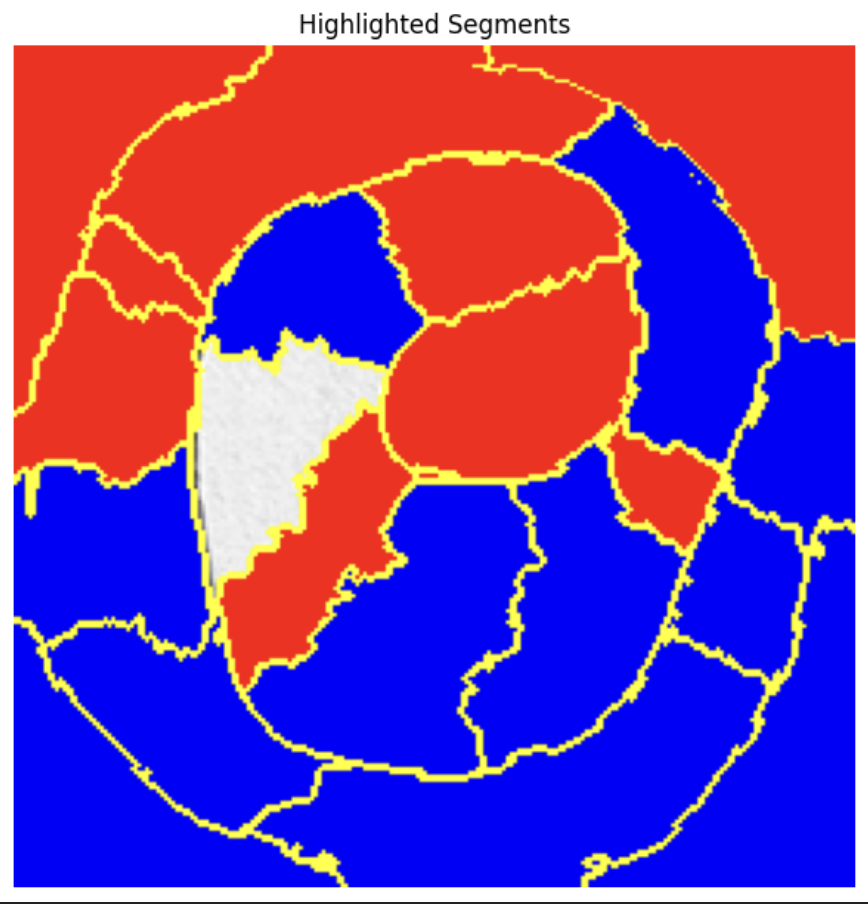


The above image is from another ipynb notebook.

# Supplementary Information




> This paper was presented as recently as June 2024 in CVPR, Seattle. Implementation for the same is around 2-3 months old.

> This study also presents a comparative analysis of SLICE with BayLIME and LIME.



## Keypoints:

### **Complete Workflow Summary of SLICE**
1. Load the image, preprocess it, and segment it into superpixels.
2. Get the top prediction for the original image.
3. Generate perturbations for superpixels (binary masks), Perturb the image using Gaussian blur or masking.
4. Predict outputs for perturbed images. Use these predictions to train a surrogate (Ridge regression) model.
5. Compute feature importance and stability metrics using the surrogate model.
6. Remove unstable features iteratively using sign entropy and rank consistency metrics, and optimize sigma for Gaussian blur.
7. Identify stable, meaningful features that contribute to the model's prediction.


###### **Main Contributions of the Study**
1. Novel Feature Selection method SEFE (Sign Entropy based Feature Elimination) to eliminate spurious superpixels
2. Gaussian Blur to generate perturbations close to the image considered for explanation (IE). To adaptively select sigma value using a novel method based on Adjusted R^2 metric.
3. New metrics to measure consistency
      - Average Sign Flip Entropy (ASFE): measure of variability in sign of superpixels across multiple runs
      - Average Rank Similarity: asseses consistency in ranking importance of superpixels across different runs
      - Combined Consistency Metric: quantify both ASFE and ARS


## Comparison Between SLICE and LIME

SLICE is an enhanced and stabilized version of LIME, addressing its well-known inconsistencies.

### Key Differences:

#### 1. **Consistency in Explanations**:
   - **LIME**: Generates explanations that vary across runs due to random sampling, leading to:
     - **Sign flips**: A superpixel may change from positive to negative importance or vice versa.
     - **Rank inconsistencies**: Relative importance rankings of superpixels are unstable.
   - **SLICE**:
     - Uses **Sign Entropy-based Feature Elimination (SEFE)** to remove spurious superpixels with high sign entropy, ensuring stable signs.
     - Introduces **Average Rank Similarity (ARS)** for consistent ranking of superpixel importance.

#### 2. **Perturbation Method**:
   - **LIME**: Perturbs images by assigning zero values to all pixels in a superpixel. This often creates perturbed images far from the original, violating the locality assumption.
   - **SLICE**:
     - Adopts **Adaptive Gaussian Blur** to create perturbations closer to the original image, maintaining the locality assumption while allowing enough variation for learning.
     - Dynamically adjusts the sigma parameter of the Gaussian blur using an optimization criterion (adjusted \( R^2 \)).

#### 3. **Metrics for Consistency and Fidelity**:
   - **Consistency**:
     - SLICE introduces **Average Sign Flip Entropy (ASFE)** and ARS to measure and improve stability in explanations.
   - **Fidelity**:
     - SLICE uses **Area Over Perturbation Curve (AOPC)** and traditional insertion/deletion metrics to evaluate how well explanations align with the model's predictions.
     - Results show higher fidelity and lower probability of generating contradictory results.

#### 4. **Algorithmic Enhancements**:
   - SLICE incorporates:
     - **Kernel Density Estimation (KDE)** to measure sign entropy and eliminate unstable superpixels.
     - **Iterative refinement** of selected features until a stable subset is achieved.
   - SLICE implementation aligns with this through:
     - Entropy computation for superpixels.
     - Iterative feature selection and ranking stabilization.

#### 5. **Statistical Validation**:
   - SLICE conducts rigorous statistical validation (e.g., Wilcoxon rank tests) to confirm significant improvements over LIME.


### Improvements Over LIME:
- SLICE addresses LIME’s randomness and instability through enhanced perturbation and feature selection mechanisms.
- It offers better control over model behavior, especially in domains requiring reliable and reproducible explanations, like healthcare and finance.

